# Brief Description of the Problem and Data

The Challenge Problem: 
The goal of the Kaggle competition titled "Monet Painting Dataset (New)" is to build generative models, specifically Generative Adversarial Networks (GANs), to create new images that mimic the style of the French impressionist painter Claude Monet. Participants are tasked with generating images that could plausibly pass as Monet's work, using a dataset of his paintings. The challenge is to capture the essence of Monet's style, such as his unique color palettes, brushstrokes, and composition.


Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

Generative Deep Learning Models:
Generative models are a class of artificial intelligence algorithms used in unsupervised learning. They are designed to learn the patterns and distribution of input data so that they can generate new data points that resemble the original dataset. GANs, which are a subset of generative models, consist of two neural networks that contest with each other in a game (hence "adversarial"). The generator network generates new data instances, while the discriminator network evaluates them against a set of real data instances. The goal is to train the generator to produce data indistinguishable from actual data, fooling the discriminator.

Ref: https://arxiv.org/abs/2111.13282

Image taken from: https://developers.google.com/machine-learning/gan/discriminator

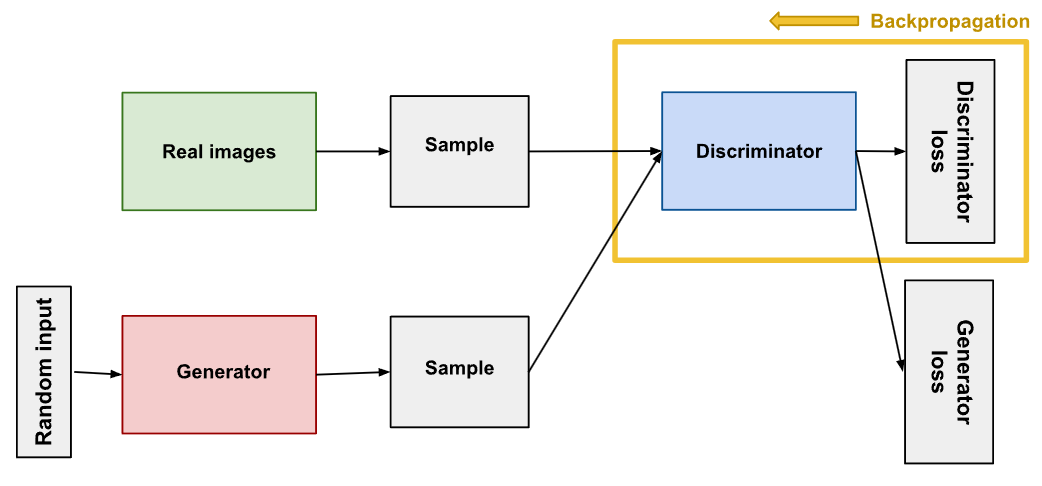

In [1]:
# Libraries

import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import time
from IPython import display

In [2]:
def show_folder_info(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        if image is not None:
            d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        else:
            print(f"Error reading image: {image_name}")
            
    for size, count in d_image_sizes.items():
        print(f'shape: {size}\tcount: {count}')

def get_image_info(directory):
    image_info = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        with Image.open(img_path) as img:
            img_info = {
                'Filename': img_name,
                'Width': img.width,
                'Height': img.height,
                'Mode': img.mode
            }
            image_info.append(img_info)
    return image_info

monet_jpg_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_jpg_dir = '/kaggle/input/gan-getting-started/photo_jpg' 

print('Monet images:')
show_folder_info(monet_jpg_dir)

print('Photo images:')
show_folder_info(photo_jpg_dir)

monet_image_info = get_image_info(monet_jpg_dir)
photo_jpg_info = get_image_info(photo_jpg_dir)

print(monet_image_info[:5])
print(photo_jpg_info[:5])

Monet images:
shape: (256, 256, 3)	count: 300
Photo images:
shape: (256, 256, 3)	count: 7038
[{'Filename': 'f4413e97bd.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '7341d96c1d.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': 'de6f71b00f.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '99d94af5dd.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '99a51d3e25.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}]
[{'Filename': 'fb97febc5f.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': 'c54c5368af.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '4a06596662.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '2629524a69.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '5e64b64de8.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}]


* Monet Images:
    * All the Monet images have a uniform shape of 256x256 pixels with 3 color channels (RGB).
    * There are a total of 300 Monet images in the dataset.

* Photo Images:
    * All the photo images are also 256x256 pixels with 3 color channels (RGB).
    * There are 7038  photo images.

* Images:
    * The filenames are alphanumeric with the .jpg extension.
    * All are in RGB color mode and have the dimensions of 256x256 pixels.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

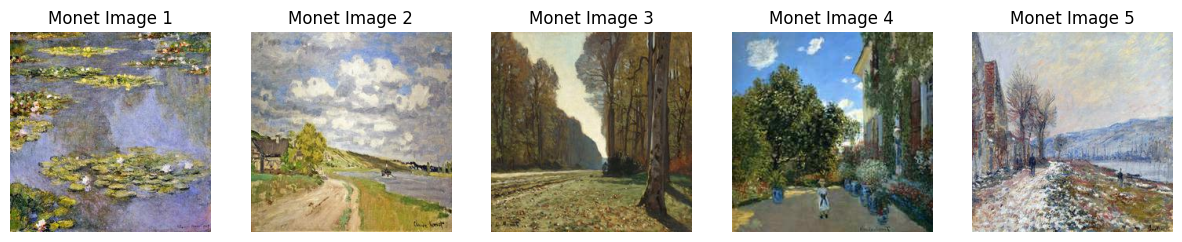

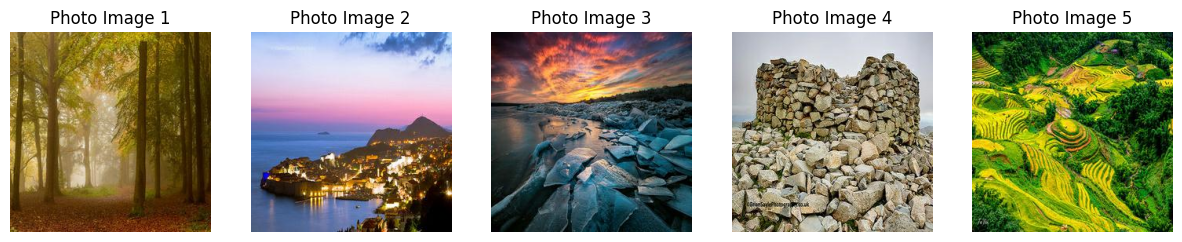

In [3]:
monet_path = Path('/kaggle/input/gan-getting-started/monet_jpg')
photo_path = Path('/kaggle/input/gan-getting-started/photo_jpg')

def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()

sample_monet_images = list(monet_path.glob('*.jpg'))[:5]
sample_photo_images = list(photo_path.glob('*.jpg'))[:5]

display_images(sample_monet_images, "Monet Image")
display_images(sample_photo_images, "Photo Image")

Monet Paintings:
* The sample of Monet paintings shows a variety of color palettes and brushstrokes, which are characteristic of his impressionist style (I did googled how they looked like)
* The images include natural landscapes with a focus on light and reflection, which are common themes in Monet's work.

Photo Images:
* The photographs are also varied and include different subjects and settings.
* The colors in the photographs are more vivid and the lines sharper than in the Monet paintings, which is typical for photos compared to impressionist paintings.
* From visual, we can see that some images are clearly not his paintings (e.g. 4) but some may be harder to distinguish (e.g. 1).


Next, we can analyze the color distributions of the images. This can be done by plotting the color histograms for a sample of images from both the Monet and photo categories. A color histogram represents the frequency of occurrence of various color intensities in an image. Analyzing these histograms will help us understand the common color profiles in Monet's paintings versus the photographs, which can be very useful when designing the generator network of the GAN to replicate Monet's style.

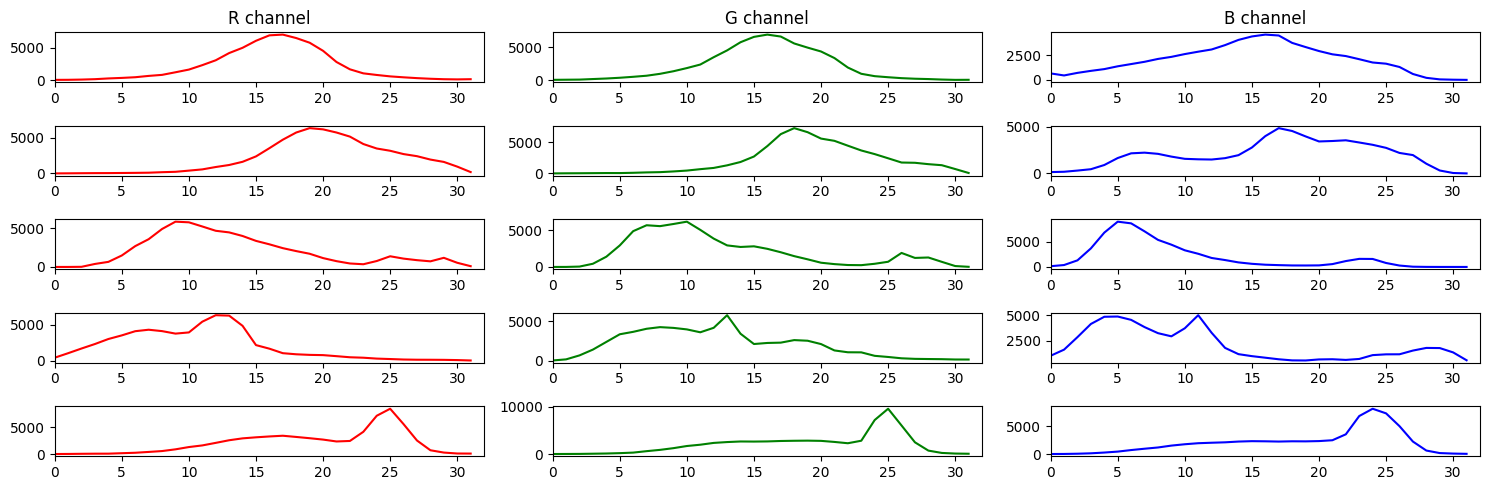

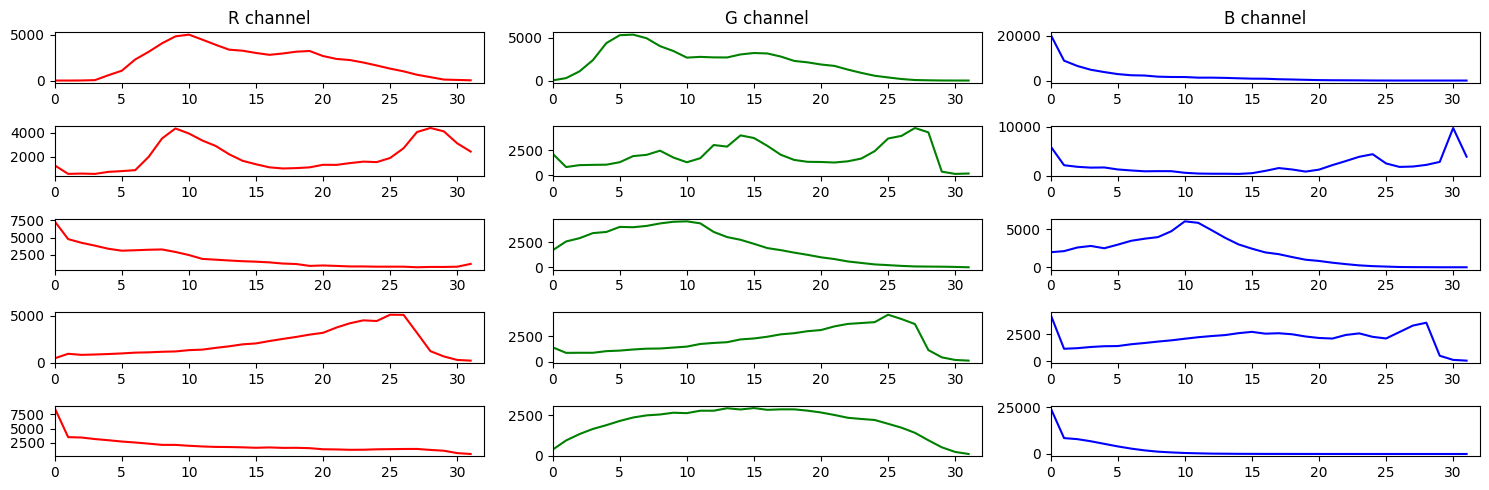

In [4]:
def plot_color_histograms(image_paths, title):
    plt.figure(figsize=(15, 5))
    
    bins = 32
    
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        color = ('r', 'g', 'b')
        for j, col in enumerate(color):
            histr = cv2.calcHist([img], [j], None, [bins], [0, 256])
            plt.subplot(len(image_paths), 3, i * 3 + j + 1)
            plt.plot(histr, color=col)
            plt.xlim([0, bins])
            if i == 0:
                plt.title(f'{col.upper()} channel')
        
        plt.tight_layout()

plot_color_histograms(sample_monet_images, "Monet Image Histogram")
plot_color_histograms(sample_photo_images, "Photo Image Histogram")

The color histograms for both Monet's paintings and photo images are shown above.

Monet Images Histograms:
* The R channel histograms tend to have a broader distribution, indicating a wider variety of red tones in the images.
* The G channel histograms are somewhat flatter, suggesting a more even spread of green tones throughout the images.
* The B channel histograms show peaks at different levels, which may correspond to prominent blue elements in Monet's paintings, such as the sky or water.

These colour intensities seems reasonable as characteristic of Monet's palette, such as blues and greens from his famous water lilies and garden scenes. The histograms also has more blending and a broader distributions, which is typical of mixed brushstrokes in paintings.

Photo Images Histograms:
* The R channel histograms have sharp peaks, which may indicate the presence of specific objects or features with strong red colors.
* The G channel histograms appear to be less varied, with some images showing a more concentrated distribution of green tones.
* The B channel histograms show variability, with some images having a very pronounced blue presence, likely reflecting scenes with significant amounts of sky or water.

The histograms for the photo images generally show sharper peaks and possibly a more varied color distribution, reflecting the diverse and vivid coloration found in real-life scenes captured by modern cameras.
Certain colors may dominate depending on the scene. For example, the photograph of the sky at sunset shows a significant peak in red and orange tones. 


In general, compared to the photo images, the Monet histograms may appear more blended and less peaked, which is indicative of the softer transitions and brushwork in impressionist painting. In contrast, the histograms for the photo images show more defined peaks and valleys, reflecting the sharper and more defined content of photographic images.

# Model Architecture

For the pre-processing, we will load the images from TFRecord files, normalize and resize the images, and apply data augmentation transformations. The datasets are then batched and prefetched to optimize the training loop.

Normalisation:
* This normalization is applied because the generator's output layer typically uses the tanh activation function, which produces values in this range.
* Reshaping: The images are reshaped to ensure they have the correct dimensions after being decoded.

Augmentation:
* Random Jittering and Cropping: Images are resized to 286x286 and then randomly cropped back to 256×256. 
* Random Rotation: Images are randomly rotated across different degrees.

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # If TPU is detected, use the GCS path
    GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
except ValueError:
    # If no TPU is detected, use the local path
    GCS_PATH = '/kaggle/input/gan-getting-started/'

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalise
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image

# read TFRecord
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# augment
def data_augment(image):
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

monet_ds = load_dataset(MONET_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


Displaying Monet images:


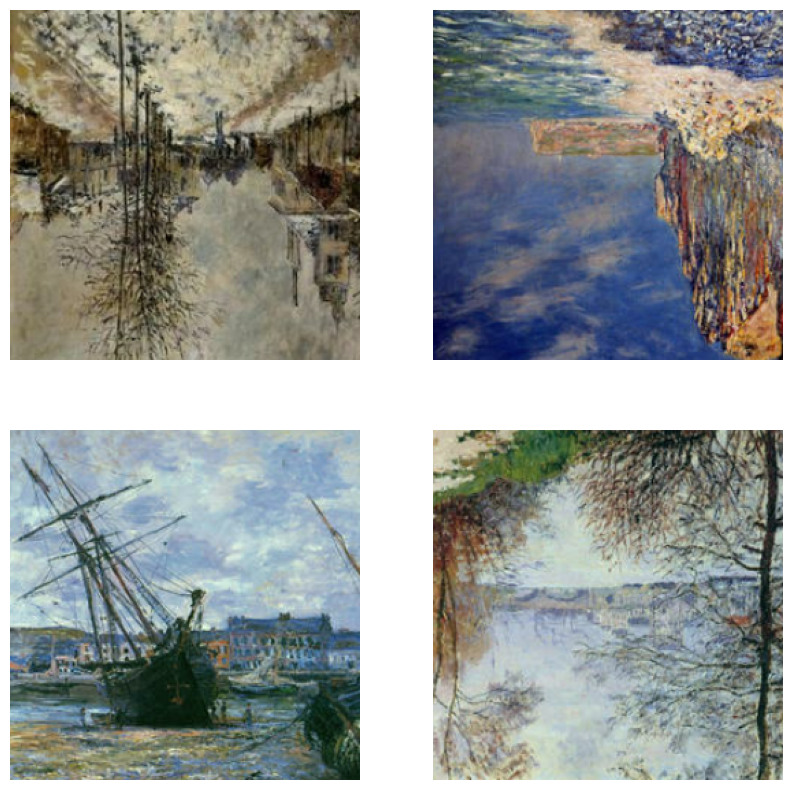

Displaying Photo images:


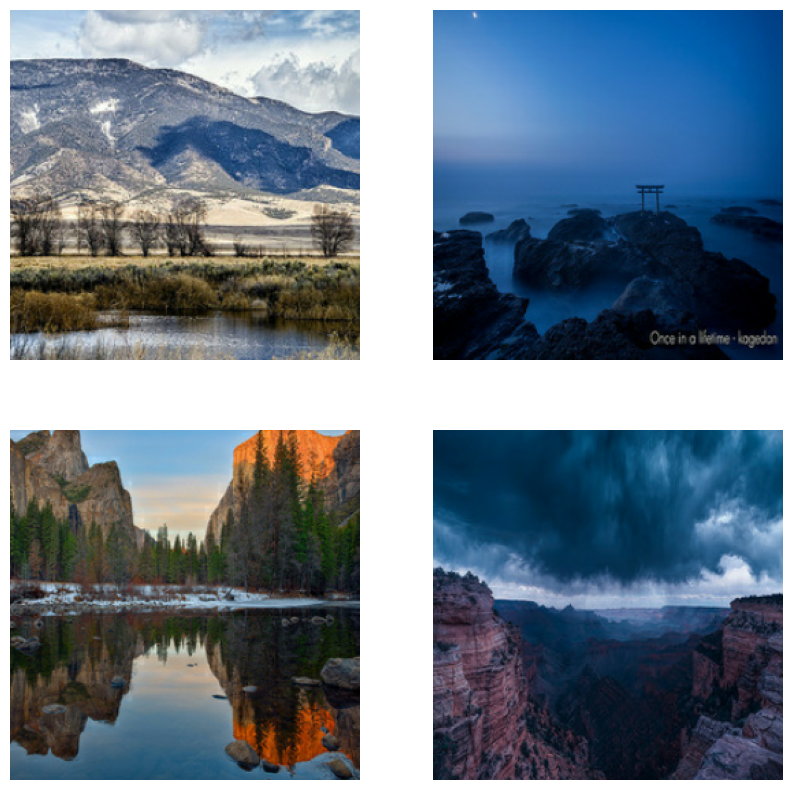

In [7]:
# check that it works 

def show_batch(dataset):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):
        for i in range(BATCH_SIZE):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow((images[i].numpy() + 1) / 2)
            plt.axis("off")
    plt.show()

print("Displaying Monet images:")
show_batch(monet_ds)

print("Displaying Photo images:")
show_batch(photo_ds)

For this task, we will use a Deep Convolutional GAN (DCGAN) structure, which is effective for image generation tasks.

GAN Architecture Overview:

* The generator is designed to create new images that resemble the training data.
* The discriminator is a binary classifier that determines whether an image looks like a real image from the dataset or a fake image produced by the generator.
* During training, the generator and discriminator are in a constant "adversarial" battle. The generator aims to produce increasingly realistic images, while the discriminator strives to get better at distinguishing real images from fakes.

Ref: https://arxiv.org/abs/1511.06434v2

Generator Architecture:

* Input Layer:
    * The generator begins with a dense layer that takes a noise vector (latent dimension) as input.
    * This noise vector is randomly generated and serves as the basis for image generation.


* Upscaling Layers:
    * The output of the dense layer is reshaped to form the initial "image" structure.
    * A series of transposed convolutional layers (Conv2DTranspose) follow.
    * These layers gradually upscale the image to a higher resolution. The upscaling is achieved by increasing the spatial dimensions (height and width) of the output.


* Batch Normalization:
    * After each transposed convolutional layer, batch normalization is applied.
    * This stabilizes and normalizes the inputs to the next layer, helping to combat issues in training deep networks.


* Activation Functions:
    * LeakyReLU activation functions are used for intermediate layers.
    * LeakyReLU allows a small gradient when the unit is not active, helping to keep the gradients flowing through the architecture.


* Output Layer:

    * The final layer uses a tanh activation function.
    * This layer outputs the generated image with pixel values normalized between -1 and 1.


Discriminator Architecture:

* Input Layer:
    * The discriminator takes an image (either real or generated by the generator) as input.


* Downscaling Layers:
    * A series of convolutional layers (Conv2D) progressively downscale the image.
    * Downscaling is achieved by reducing the spatial dimensions while increasing the depth (number of filters).


* Activation Functions:
    * LeakyReLU is used here as well, allowing the network to learn non-linear decision boundaries.


* Dropout Layers:
    * Dropout layers are included to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training time.


* Output Layer:
    * The network end with a dense layer that outputs a single value.
    * This value represents the discriminator's assessment of whether the input image is real or fake.
    

In [8]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[256, 256, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

Next, we will define the appropriate loss functions to train the Generative Adversarial Network (GAN). 
 
Binary Cross-Entropy Loss:
* The chosen loss function is binary cross-entropy. It's suitable for binary classification tasks, which fits the discriminator's role in classifying images as real or fake.


Discriminator Loss:
* The discriminator loss comprises two parts: the loss from real images and the loss from fake images.
    * real_loss calculates how well the discriminator classifies real images as real. It compares the discriminator's predictions on real images (real_output) against an array of 1s (since real images should be classified as 1).
    * fake_loss calculates how well the discriminator classifies fake images as fake. It compares the discriminator's predictions on fake images (fake_output) against an array of 0s.
* The total discriminator loss is the sum of real_loss and fake_loss.


Generator Loss:
* The generator's goal is to fool the discriminator into thinking its generated images are real.
* The generator loss measures how well it accomplishes this task.
* It compares the discriminator's predictions on the fake images against an array of 1s because the generator is successful if the discriminator thinks these fake images are real (i.e., classifies them as 1).


In general, the discriminator loss encourages the discriminator to correctly classify real images as real and fake images as fake while the generator loss encourages the generator to produce images that are indistinguishable from real images, as judged by the discriminator. These loss functions work together to create a feedback loop where the generator continuously improves its ability to generate realistic images, and the discriminator improves its ability to distinguish real from fake. Interestingly, the generator and discriminator are trained simultaneously: as the generator becomes better at generating realistic images, the discriminator's task becomes more challenging, and vice versa.

Ref: https://medium.com/@worthlessFella/basic-gan-loss-function-958ac5c36712

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Next, we will define separate optimizers for the generator and the discriminator.

We will utilise Adam Optimizer, which combines the benefits of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).
* For learning rate, we use a small rate to allow a smooth and stable training.
* We also include a exponential decay rate at beta_1 = 0.5 to adjut the learning rate dynamically.

In [10]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

Next, we will create the training loop for the GAN by iteratively updating the generator and the discriminator. 

* We create a function train_step that perform one training step for both the generator and discriminator with a random noise vector. 
* We use gradienttape to track the operations for auto differentiation.
* Then, the generator will create images from noise while the discriminator discern the images. 
* We calculate the losses and derive gradients of losses with respect to model weights and update them based on calculated gradients.
* This process iterate across batches for each epoch and in an order between the generator/discriminator.
* At the same time, we visualize the progress, including the generator and discriminator losses and the training time per epoch.

In [11]:
EPOCHS = 50

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    epoch_times = []

    for epoch in range(epochs):
        start_time = time.time()
        gen_loss_epoch = []
        disc_loss_epoch = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch.append(gen_loss)
            disc_loss_epoch.append(disc_loss)

        gen_losses.append(np.mean(gen_loss_epoch))
        disc_losses.append(np.mean(disc_loss_epoch))
        epoch_duration = time.time() - start_time
        epoch_times.append(epoch_duration)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, epoch_duration))

    return gen_losses, disc_losses, epoch_times


In [12]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

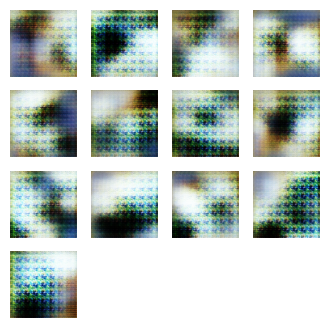

Time for epoch 50 is 53.15680289268494 sec


In [13]:
num_examples_to_generate = 13
seed = tf.random.normal([num_examples_to_generate, latent_dim])

gen_losses, disc_losses, epoch_times = train(monet_ds, EPOCHS)

# Results and Analysis

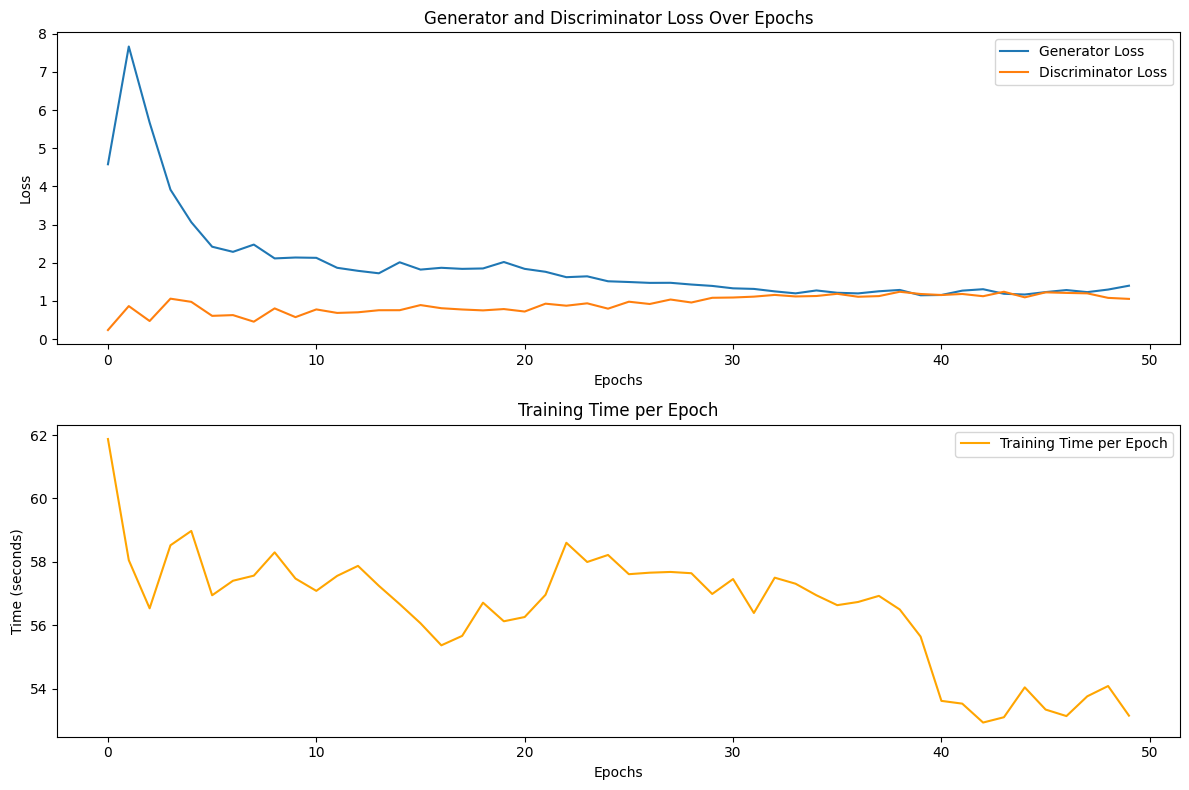

In [14]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, gen_losses, label='Generator Loss')
plt.plot(epochs_range, disc_losses, label='Discriminator Loss')
plt.title('Generator and Discriminator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, epoch_times, label='Training Time per Epoch', color='orange')
plt.title('Training Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()


Training Losses for GAN:

The top chart displays the generator and discriminator losses over epochs. Both losses start at different values with the generator loss initially being higher. Over time, both losses decrease, which suggests that both networks (generator and discriminator) are learning. The generator's loss decreases sharply at the beginning, which is typical as it starts learning from a naive state. It's important that the generator loss doesn't go to zero, as this would indicate that it is fooling the discriminator too easily, which is not ideal for the model's ability to generate diverse outputs. The discriminator's loss also decreases but at a slower rate, which could indicate that it is becoming better at distinguishing real images from the fake ones produced by the generator. It is desirable to have the discriminator loss neither too high nor too low, suggesting a balanced competition between the generator and discriminator.

Training Time per Epoch:

The bottom chart shows the training time per epoch in seconds. There's a spike in the beginning which might indicate some initial setup or caching effect, but overall, the time per epoch seems to be decreasing slightly or stabilizing as the epochs progress.

Hyperparameter Tuning:

* Manual Tuning Approach:
    * Due to resource and time constraints, an automated hyperparameter tuning process was not used.
    * Focused on manually tuning the learning rate and beta values of the Adam optimizer.

* Selected Hyperparameters:
    * Learning Rate: Initially started with 0.01 but found 0.0002 to be more effective, as it is a common and stable starting point for GAN training. Also tried increasing it but led to unstable training and did not converge.
    * Beta Values of Optimizer: The beta value of 0.5 was maintained from the start, as it helps adjust the learning rate based on a shorter history of gradients, aiding in the rapidly changing GAN training environment.
    * Tried different batch sizes and smaller batch sizes actually led to more noise. Larger batch size also did not lead to better performance.
    * Varied the size of the latent dimension vector. Found that very large or very small sizes either did not capture enough complexity of the data or made the training process computationally expensive without much gain.

* Alternative Loss Functions and Optimizers:
    * AdaGrad Experimentation: Experimented with AdaGrad as an alternative to the Adam optimizer. AdaGrad adapts the learning rate to the parameters, performing larger updates for infrequent parameters, and smaller updates for frequent ones.
    * Ultimately, AdaGrad did not lead to significant improvements over Adam for this project, particularly due to the nature of the image data being dense rather than sparse.
    * Retained the Adam optimizer for its adaptability and overall balanced performance in GAN training.
    
Note: Additional models ran separately but not shown in notebook due to kernel size limit.

# Submission and Conclusion

In [15]:
num_images_to_generate = 7000

output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

for i in range(num_images_to_generate):
    noise = tf.random.normal([1, latent_dim])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1.0) * 127.5
    generated_image = tf.cast(generated_image, tf.uint8)
    tf.keras.preprocessing.image.save_img(
        os.path.join(output_dir, f'image_{i}.jpg'),
        generated_image[0],
        data_format='channels_last'
    )

print(f'{num_images_to_generate} images generated and saved to {output_dir}')

7000 images generated and saved to generated_images


In [16]:
import shutil

shutil.make_archive('images', 'zip', 'generated_images')

'/kaggle/working/images.zip'

In [17]:
output_dir = '/kaggle/working/generated_images'
zip_file = '/kaggle/working/images.zip'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

for filename in os.listdir('/kaggle/working'):
    file_path = os.path.join('/kaggle/working', filename)
    if os.path.isfile(file_path) and filename != 'images.zip':
        os.remove(file_path)

Results:

![monet results.jpg](<attachment:monet results.jpg>)
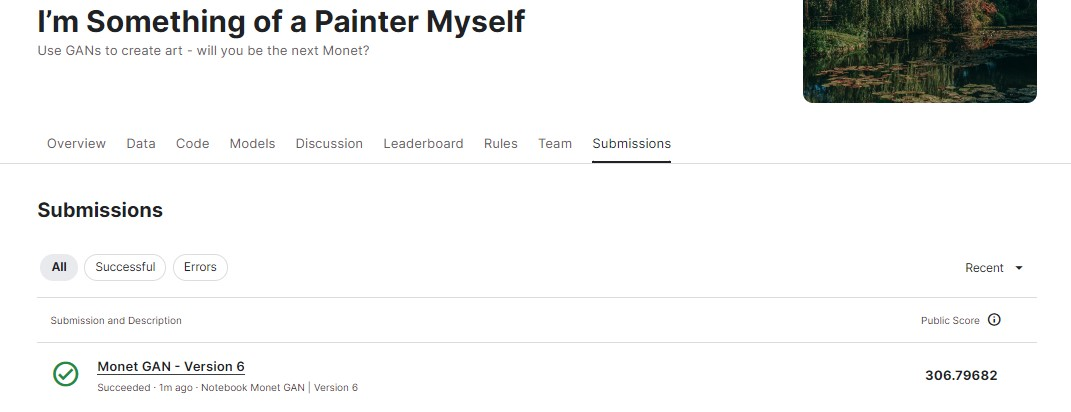

Summary:

Here, the goal was to create a Generative Adversarial Network (GAN) capable of generating images that mimic the style of the French impressionist painter Claude Monet. The approach taken involved using a dataset of Monet's paintings to train a Deep Convolutional GAN (DCGAN). This proved to be quite difficult as we were not taught on the steps in the module and the project encompassed several steps, including preprocessing the images to normalize their pixel values and applying data augmentation to increase the diversity of the training data. The DCGAN architecture was composed of a generator, which creates new images from a noise vector, and a discriminator, which attempts to distinguish between real and generated images. The models were trained using binary cross-entropy loss and the Adam optimizer with carefully selected hyperparameters. After training, the generator was used to produce new images that were intended to resemble Monet's artwork. Interestingly, while it doesnt sound complicated, the long training process makes it crucial for the steps to be handled correctly.

Takeaways:

Firstly, the choice of normalization and data augmentation techniques played a significant role in the training stability and the quality of the generated images. Secondly, the learning rate and beta parameters of the Adam optimizer were critical for convergence and had to be finely tuned to achieve the desired results. The manual tuning process, although time-consuming, was necessary due to resource constraints. This was interesting because this is the first time I truly understand the computational constraints of powerful models. Another learning point is the intricacies between the balance of the generator and discriminator, which was maintained by monitoring their respective losses, ensuring that neither became too powerful and compliment each other for their own purposes.

Future Improvements:

One promising direction is the use of CycleGAN, an architecture designed for image-to-image translation tasks without paired examples. In the context of Monet painting generation, CycleGAN could potentially offer better performance than DCGAN because it is designed to capture and translate the style of one image domain (e.g., photographs) into another (e.g., Monet paintings). This is particularly relevant for style transfer tasks where the goal is to mimic a specific artistic style. CycleGAN includes a cycle consistency loss that ensures the original image can be reconstructed from the generated image, which could help in preserving the content of the photographs while transferring the style of Monet's paintings. This approach could lead to more convincing and stylistically coherent generated images than the DCGAN used in this project.

Ref: https://arxiv.org/abs/1703.10593